In [1]:
%pylab inline
# import igraph
import matplotlib.pyplot as plt
import sys
sys.path.append('../code')
from rnnmodel import *
from notebookutils import *

Populating the interactive namespace from numpy and matplotlib


## 1. Generate parameters used to generate TAP dynamics

In [2]:
# set noise seed
noise_seed = 2022
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))

model_type = 1 # 1: Ux + b, 0: Ux

# Ns = no. of latent variables, Nr = no. of neurons, Ny = no. of inputs
Ns, Nr, Ny = 10, 500, 10

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
smoothing_filter = signal.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)


# ground truth TAP model parameters

lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics

G   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation

self_coupling_on, sparsity_J, gain_J, Jtype  = 1, 0.5, 3, 'nonferr' # interaction matrix settings
J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on)


if model_type:
    gain_U = 1
    U   = gain_U*np.random.randn(Nr,Ns) # embedding matrix
else:
    gain_U = 3
    U   = gain_U*np.random.rand(Nr,Ns) # embedding matrix

if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]

# concatenate parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

noise_seed = 2022


### Visualize interaction matrix J

In [3]:
# requires igraph to be installed and imported
cmap = matplotlib.cm.get_cmap("coolwarm")
g = igraph.Graph.Adjacency((J !=0).tolist())
edge_weights = []
edge_colors = []
for (i,j) in g.get_edgelist():
    edge_weights.append(J[i,j])
    edge_colors.append(cmap(0.8*(J[i,j] > 0))[0:3])
edge_weights = np.abs(edge_weights)

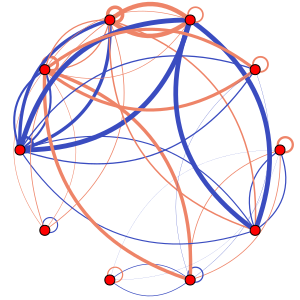

In [4]:
igraph.plot(g, layout=g.layout("circle"), bbox=(300,300), margin=20, 
            vertex_size=10,
            edge_arrow_size=0.01, 
            edge_width = 5*edge_weights, edge_color = edge_colors)

## 2. Generate training and validation data

In [5]:
B_train, B_val = 25000, 500      # No. of batches
T = 30                           # No. of time steps 
T_clip  = 20                     # No. of time steps to clip
T_low, T_high = 2, 5             # range of time periods for which input is held constant
yG_low, yG_high = 2, 50          # range of input gains

y_train, _, r_train = generate_TAPdynamics(theta, params, B_train, T+T_clip, T_low, T_high, yG_low, yG_high)

y_val, _, r_val = generate_TAPdynamics(theta, params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high)

In [6]:
# Add baseline to make neural activity positive

baseline = -np.min(r_train) if model_type else 0
r_train += baseline
r_val += baseline

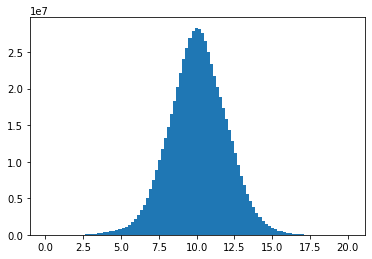

In [7]:
# Plot histogram of training data

plt.hist(r_train.flatten(),100)
plt.show()

In [8]:
"""
Convert ground truth dynamics data to torch tensors
"""    

y_train = torch.tensor(y_train.transpose(0,2,1), dtype=torch.float32) # input signal
r_train = torch.tensor(r_train.transpose(0,2,1), dtype=torch.float32) # target neural activity

y_val = torch.tensor(y_val.transpose(0,2,1), dtype=torch.float32) # input signal
r_val = torch.tensor(r_val.transpose(0,2,1), dtype=torch.float32) # target neural activity


print('No. of batches x T x No. of neurons')
print('Training data:', r_train.shape, 'Validation data:', r_val.shape)

No. of batches x T x No. of neurons
Training data: torch.Size([25000, 50, 500]) Validation data: torch.Size([500, 50, 500])


## 3. Create RNN model

In [9]:
N_input, N_hidden, N_output = Ny, 1000, Nr

use_cuda = True

tapbrain = RNN(N_input, N_hidden, N_output, use_cuda)

loss_fn = nn.MSELoss()

if use_cuda and torch.cuda.is_available():
    tapbrain.cuda()
    
print(torch.cuda.is_available())

True


## 4. Training

In [10]:
NIters = 800000  # No. of iterations for training the RNN
batch_size = 16  # batch size for training the RNN
epoch = B_train//batch_size

learningrate = 1e-5
optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate, betas=(0.9, 0.999))

train_loss, val_loss = [], []

In [11]:
t_st = time.time()
 
for iteration in range(NIters):
    
    if iteration == NIters//2:
        optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate/2, betas=(0.9, 0.999))
    
    optimizer.zero_grad()
    
    batch_index = torch.randint(0, B_train,(batch_size,))
    rhat_train  = tapbrain(y_train[batch_index].cuda())[0]
    
    mse_train = loss_fn(r_train[batch_index,T_clip:].cuda(), rhat_train[:,T_clip:])
    
    mse_train.backward()  
    
    optimizer.step()
    
    if (iteration + 1) % epoch == 0:
        with torch.no_grad():
            rhat_val = tapbrain(y_val.cuda())[0]
            mse_val = loss_fn(r_val[:,T_clip:].cuda(), rhat_val[:,T_clip:])
            
        train_loss.append(mse_train.item())
        val_loss.append(mse_val.item())
        
    if (iteration + 1) % 5000 == 0:
        #print('[%d] training loss: %.5f' %(iteration + 1, mse_train.item()))
        print(f"[{iteration+1}] time elapsed = {(time.time() - t_st)/60:.1f} mins , log training loss = {np.log10(mse_train.item()):.2f} ")

print('Finished training')
t_en = time.time()

print(f"Time elapsed = {t_en - t_st:.1f}s")

[5000] time elapsed = 3.0 mins , log training loss = -0.37 
[10000] time elapsed = 5.9 mins , log training loss = -0.53 
[15000] time elapsed = 9.0 mins , log training loss = -0.67 
[20000] time elapsed = 12.0 mins , log training loss = -0.70 
[25000] time elapsed = 15.1 mins , log training loss = -0.68 
[30000] time elapsed = 18.2 mins , log training loss = -0.63 
[35000] time elapsed = 21.3 mins , log training loss = -0.75 
[40000] time elapsed = 24.4 mins , log training loss = -1.02 
[45000] time elapsed = 27.5 mins , log training loss = -1.19 
[50000] time elapsed = 30.7 mins , log training loss = -1.11 
[55000] time elapsed = 33.9 mins , log training loss = -0.98 
[60000] time elapsed = 37.1 mins , log training loss = -0.92 
[65000] time elapsed = 40.4 mins , log training loss = -1.38 
[70000] time elapsed = 43.7 mins , log training loss = -1.28 
[75000] time elapsed = 46.9 mins , log training loss = -0.99 
[80000] time elapsed = 50.1 mins , log training loss = -1.43 
[85000] time

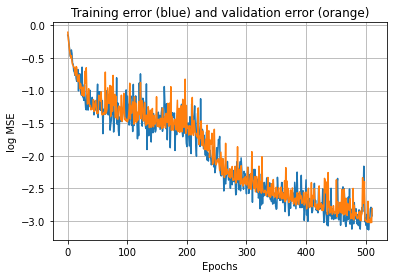

In [12]:
"""
Plot the training and validation MSE as a function of epochs
"""
plt.plot(np.log10(np.array(train_loss)))
plt.plot(np.log10(np.array(val_loss)))
plt.title('Training error (blue) and validation error (orange)')
plt.ylabel('log MSE')
plt.xlabel('Epochs')
plt.grid(True)
plt.show()

In [13]:
"""
Convert model to cpu and run the entire training and test data through the model
"""

tapbrain.cpu()
tapbrain.use_cuda = False

with torch.no_grad():
    rhat_val    = tapbrain(y_val)[0]


In [14]:
"""
Convert torch tensors to numpy
"""

del y_train, r_train

y_val    = y_val[:,T_clip:].data.numpy()
r_val    = r_val[:,T_clip:].data.numpy()
rhat_val = rhat_val[:,T_clip:].data.numpy()


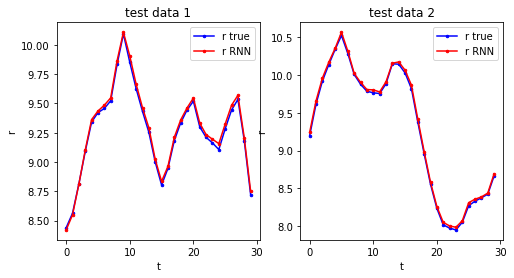

In [15]:
"""
Plot fits to test data
"""
fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(r_val[5,:,1],'b.-',markersize=5)
ax[0].plot(rhat_val[5,:,1],'r.-',markersize=5)
ax[0].set(xlabel='t', ylabel='r', title ='test data 1')
ax[0].legend(['r true', 'r RNN'])

ax[1].plot(r_val[2,:,0],'b.-',markersize=5)
ax[1].plot(rhat_val[2,:,0],'r.-',markersize=5)
ax[1].set(xlabel='t', ylabel='r', title ='test data 2')
ax[1].legend(['r true', 'r RNN'])

plt.show()

In [16]:
"""
Generate another test data set
"""

B_test = 5  # No. of batches
T_test = 1000 # No. of time steps 

y_test, _, r_test = generate_TAPdynamics(theta, params, B_test, T_test+T_clip, T_low, T_high, yG_low, yG_high)

r_test = r_test.transpose(0,2,1) + baseline
y_test = torch.tensor(y_test.transpose(0,2,1), dtype=torch.float32) 

print('No. of batches x T x No. of neurons')
print('Test data:', r_test.shape)

No. of batches x T x No. of neurons
Test data: (5, 1020, 500)


In [17]:
"""
Run model on test data
"""
with torch.no_grad():
    rhat_test = tapbrain(y_test)[0]

y_test    = y_test[:,T_clip:].data.numpy()
r_test    = r_test[:,T_clip:]
rhat_test = rhat_test[:,T_clip:].data.numpy()

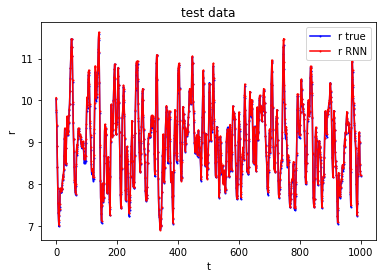

In [18]:
"""
Test data
"""
plt.plot(r_test[0,:,0],'b.-',markersize=2)
plt.plot(rhat_test[0,:,0],'r.-',markersize=2)
plt.xlabel('t')
plt.ylabel('r')
plt.title('test data')
plt.legend(['r true', 'r RNN'])
plt.show()

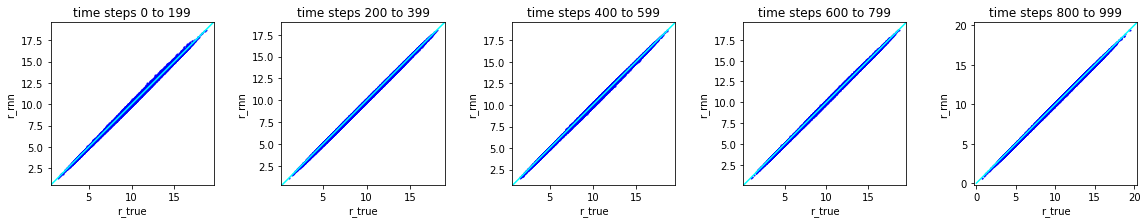

In [19]:
"""
Scatter plot for test data for every C time steps
"""
C = 200
N = T_test//C


fig, ax = plt.subplots(1,N,figsize=(4*N,3))
rmax = np.max(r_test)+2
for ni in range(N):
    ax[ni].plot(r_test[:,ni*C:(ni+1)*C].flatten(), rhat_test[:,ni*C:(ni+1)*C].flatten(),'b.',markersize=2)
    ax[ni].axis('square')
    ax[ni].plot([0,rmax],[0,rmax],color='cyan')
    ax[ni].set(xlabel='r_true', ylabel='r_rnn', title = 'time steps ' +str(ni*C)+ ' to ' + str(ni*C + C-1))

In [20]:
"""
Save trained brain and required variables
"""

brain_name = '../data/brains/' + 'Ns_'+ str(Ns) + '_Nr_' + str(Nr) + '_noiseseed_' + str(noise_seed)
torch.save(tapbrain,brain_name + '.pt')

params['baseline'] = baseline
with open(brain_name + '_params.pkl', 'wb') as f:  
    pickle.dump([theta, params], f)
f.close()

In [21]:
brain_name

'../data/brains/Ns_10_Nr_500_noiseseed_2022'

## Plotting

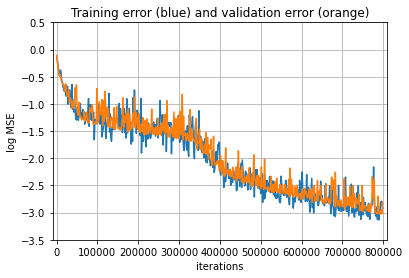

In [22]:
"""
Plot the training and validation MSE as a function of iterations
"""
iterations = np.arange(0,len(train_loss))*epoch
plot(iterations, np.log10(np.array(train_loss)))
plot(iterations, np.log10(np.array(val_loss)))
title('Training error (blue) and validation error (orange)')
ylabel('log MSE')
xlabel('iterations')
grid(True)
axis([-10000, 810000, -3.5, 0.5])
savefig("/home/rvraju/Desktop/Inferring_Inference/brain_2022_Nr_500/training.pdf")
show()

In [23]:
# requires igraph to be installed and imported
cmap = matplotlib.cm.get_cmap("coolwarm")
g = igraph.Graph.Adjacency((J !=0).tolist())
edge_weights = []
edge_colors = []
for (i,j) in g.get_edgelist():
    edge_weights.append(J[i,j])
    edge_colors.append(cmap(0.9*(J[i,j] > 0))[0:3])
edge_weights = np.abs(edge_weights)

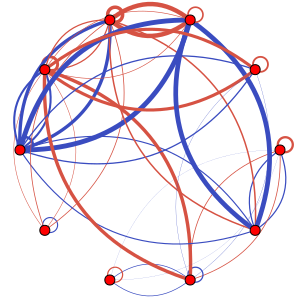

In [24]:
igraph.plot(g, "/home/rvraju/Desktop/Inferring_Inference/brain_2022_Nr_500/latent_graph.pdf",
            layout=g.layout("circle"), bbox=(300,300), margin=20, 
            vertex_size=10, 
            edge_arrow_size=0.01, 
            edge_width = 5*edge_weights, edge_color = edge_colors, 
           )

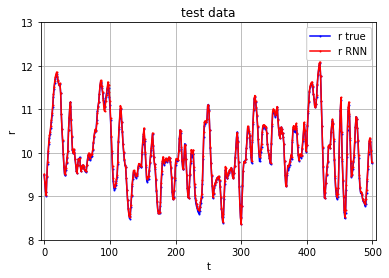

In [26]:
"""
Test data
"""
plot(r_test[0,0:500,300],'b.-',markersize=2)
plot(rhat_test[0,0:500,300],'r.-',markersize=2)
xlabel('t')
ylabel('r')
title('test data')
legend(['r true', 'r RNN'])
axis([-5,505,8,13])
grid(True)
savefig("/home/rvraju/Desktop/Inferring_Inference/brain_2022_Nr_500/example_neural_activity.pdf")
show()

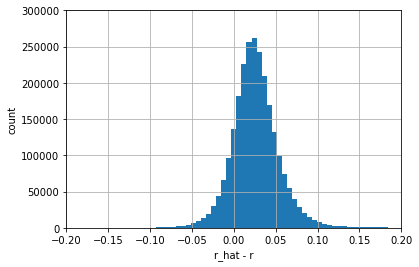

In [27]:
# Plot histogram of error
hist((rhat_test - r_test).flatten(),bins=np.linspace(-0.6,0.6,200))
axis([-0.2,0.2,0,300000])
grid(True)
xlabel('r_hat - r')
ylabel('count')
savefig("/home/rvraju/Desktop/Inferring_Inference/brain_2022_Nr_500/test_err_hist.pdf")
show()